In [264]:
from __future__ import print_function, division, absolute_import
import numpy as np
from keras.preprocessing.image import Iterator
from scipy import linalg,signal

In [5]:
class NumpyArrayIterator(Iterator):
    """Iterator yielding data from a Numpy array.
    # Arguments
        x: Numpy array of input data.
        y: Numpy array of targets data.
        audio_data_generator: Instance of `AudioDataGenerator`
            to use for random transformations and normalization.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the audio
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            audio (if `save_to_dir` is set).
        save_format: Format to use for saving sample audio
            (if `save_to_dir` is set).
        subset: Subset of data (`"training"` or `"validation"`) if
            validation_split is set in AudioDataGenerator.
    """

    def __init__(self, x, y, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 data_format=None,
                 save_to_dir=None, save_prefix='', save_format='png',
                 subset=None):
        if y is not None and len(x) != len(y):
            raise ValueError('`x` (images tensor) and `y` (labels) '
                             'should have the same length. '
                             'Found: x.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))
        if subset is not None:
            if subset not in {'training', 'validation'}:
                raise ValueError('Invalid subset name:', subset,
                                 '; expected "training" or "validation".')
            split_idx = int(len(x) * image_data_generator._validation_split)
            if subset == 'validation':
                x = x[:split_idx]
                if y is not None:
                    y = y[:split_idx]
            else:
                x = x[split_idx:]
                if y is not None:
                    y = y[split_idx:]
        if data_format is None:
            data_format = 'channels_last'
        self.x = np.asarray(x, dtype=K.floatx())
        if self.x.ndim != 3:
            raise ValueError('Input data in `NumpyArrayIterator` '
                             'should have rank 3. You passed an array '
                             'with shape', self.x.shape)
        channels_axis = 2 if data_format == 'channels_last' else 1
        if self.x.shape[channels_axis] not in {1, 3, 4}:
            warnings.warn('NumpyArrayIterator is set to use the '
                          'data format convention "' + data_format + '" '
                          '(channels on axis ' + str(channels_axis) + '), i.e. expected '
                          'either 1, 3 or 4 channels on axis ' + str(channels_axis) + '. '
                          'However, it was passed an array with shape ' + str(self.x.shape) +
                          ' (' + str(self.x.shape[channels_axis]) + ' channels).')
        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.audio_data_generator = audio_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(NumpyArrayIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros(tuple([len(index_array)] + list(self.x.shape)[1:]),
                           dtype=K.floatx())
        for i, j in enumerate(index_array):
            x = self.x[j]
            x = self.audio_data_generator.random_transform(x.astype(K.floatx()))
            x = self.audio_data_generator.standardize(x)
            batch_x[i] = x
        if self.save_to_dir:
            raise NotImplementedError
#             for i, j in enumerate(index_array):
#                 img = array_to_img(batch_x[i], self.data_format, scale=True)
#                 fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
#                                                                   index=j,
#                                                                   hash=np.random.randint(1e4),
#                                                                   format=self.save_format)
#                 img.save(os.path.join(self.save_to_dir, fname))
        if self.y is None:
            return batch_x
        batch_y = self.y[index_array]
        return batch_x, batch_y

    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)

In [ ]:
class AudioDataGenerator(object):
    """Generate batches of tensor image data with real-time data augmentation.
     The data will be looped over (in batches).
    # Arguments
        featurewise_center: Boolean. Set input mean to 0 over the dataset, feature-wise.
        samplewise_center: Boolean. Set each sample mean to 0.
        featurewise_std_normalization: Boolean. Divide inputs by std of the dataset, feature-wise.
        samplewise_std_normalization: Boolean. Divide each input by its std.
        zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
        zca_whitening: Boolean. Apply ZCA whitening.
        roll_range: Float (fraction of total sample length). Range for random horizontal rotational shifts.
        horizontal_flip: Boolean. Randomly flip inputs horizontally.
        zoom_range: Float (fraction of zoom) or [lower, upper]. 
        
        width_shift_range: Float (fraction of total width). Range for random horizontal shifts.
        height_shift_range: Float (fraction of total height). Range for random vertical shifts.
        shear_range: Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
        
        channel_shift_range: Float. Range for random channel shifts.
        fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}.  Default is 'nearest'.
        Points outside the boundaries of the input are filled according to the given mode:
            'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
            'nearest':  aaaaaaaa|abcd|dddddddd
            'reflect':  abcddcba|abcd|dcbaabcd
            'wrap':  abcdabcd|abcd|abcdabcd
        cval: Float or Int. Value used for points outside the boundaries when `fill_mode = "constant"`.
        
        vertical_flip: Boolean. Randomly flip inputs vertically.
        rescale: rescaling factor. Defaults to None. If None or 0, no rescaling is applied,
                otherwise we multiply the data by the value provided (before applying
                any other transformation).
        preprocessing_function: function that will be implied on each input.
                The function will run after the image is resized and augmented.
                The function should take one argument:
                one image (Numpy tensor with rank 3),
                and should output a Numpy tensor with the same shape.
        data_format: One of {"channels_first", "channels_last"}.
            "channels_last" mode means that the images should have shape `(samples, height, width, channels)`,
            "channels_first" mode means that the images should have shape `(samples, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
        validation_split: Float. Fraction of images reserved for validation (strictly between 0 and 1).
   
    """

    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 zca_epsilon=1e-6,
                 rotation_range=0.,
                 width_shift_range=0.,
                 roll_range=0., 
                 brightness_range=None,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 preprocessing_function=None,
                 data_format=None,
                 validation_split=0.0):
        if data_format is None:
            data_format = 'channels_last'
        self.featurewise_center = featurewise_center
        self.samplewise_center = samplewise_center
        self.featurewise_std_normalization = featurewise_std_normalization
        self.samplewise_std_normalization = samplewise_std_normalization
        self.zca_whitening = zca_whitening
        self.zca_epsilon = zca_epsilon
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.roll_range = roll_range
        self.brightness_range = brightness_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.channel_shift_range = channel_shift_range
        self.fill_mode = fill_mode
        self.cval = cval
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rescale = rescale
        self.preprocessing_function = preprocessing_function

        if data_format not in {'channels_last', 'channels_first'}:
            raise ValueError('`data_format` should be `"channels_last"` (channel after row and '
                             'column) or `"channels_first"` (channel before row and column). '
                             'Received arg: ', data_format)
        self.data_format = data_format
        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 2
#             self.col_axis = 3
        if data_format == 'channels_last':
            self.channel_axis = 2
            self.row_axis = 1
#             self.col_axis = 2
        if validation_split and not 0 < validation_split < 1:
            raise ValueError('`validation_split` must be strictly between 0 and 1. '
                             ' Received arg: ', validation_split)
        self._validation_split = validation_split

        self.mean = None
        self.std = None
        self.principal_components = None

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise ValueError('`zoom_range` should be a float or '
                             'a tuple or list of two floats. '
                             'Received arg: ', zoom_range)
        if zca_whitening:
            if not featurewise_center:
                self.featurewise_center = True
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, which overrides '
                              'setting of `featurewise_center`.')
            if featurewise_std_normalization:
                self.featurewise_std_normalization = False
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening` '
                              'which overrides setting of'
                              '`featurewise_std_normalization`.')
        if featurewise_std_normalization:
            if not featurewise_center:
                self.featurewise_center = True
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, '
                              'which overrides setting of '
                              '`featurewise_center`.')
        if samplewise_std_normalization:
            if not samplewise_center:
                self.samplewise_center = True
                warnings.warn('This ImageDataGenerator specifies '
                              '`samplewise_std_normalization`, '
                              'which overrides setting of '
                              '`samplewise_center`.')

    def flow(self, x, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='png', subset=None):
        """Takes numpy data & label arrays, and generates batches of
            augmented/normalized data.
        # Arguments
               x: data. Should have rank 4.
                In case of grayscale data,
                the channels axis should have value 1, and in case
                of RGB data, it should have value 3.
               y: labels.
               batch_size: int (default: 32).
               shuffle: boolean (default: True).
               seed: int (default: None).
               save_to_dir: None or str (default: None).
                This allows you to optionally specify a directory
                to which to save the augmented pictures being generated
                (useful for visualizing what you are doing).
               save_prefix: str (default: `''`). Prefix to use for filenames of saved pictures
                (only relevant if `save_to_dir` is set).
                save_format: one of "png", "jpeg" (only relevant if `save_to_dir` is set). Default: "png".
        # Returns
            An Iterator yielding tuples of `(x, y)` where `x` is a numpy array of image data and
             `y` is a numpy array of corresponding labels."""
        return NumpyArrayIterator(
            x, y, self,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            subset=subset)

    def flow_from_directory(self, directory,
                            target_size=(256, 256), color_mode='rgb',
                            classes=None, class_mode='categorical',
                            batch_size=32, shuffle=True, seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            follow_links=False,
                            subset=None,
                            interpolation='nearest'):
        """Takes the path to a directory, and generates batches of augmented/normalized data.
        # Arguments
                directory: path to the target directory.
                 It should contain one subdirectory per class.
                 Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator.
                See [this script](https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d) for more details.
                target_size: tuple of integers `(height, width)`, default: `(256, 256)`.
                 The dimensions to which all images found will be resized.
                color_mode: one of "grayscale", "rbg". Default: "rgb".
                 Whether the images will be converted to have 1 or 3 color channels.
                classes: optional list of class subdirectories (e.g. `['dogs', 'cats']`).
                 Default: None. If not provided, the list of classes will
                 be automatically inferred from the subdirectory names/structure under `directory`,
                 where each subdirectory will be treated as a different class
                 (and the order of the classes, which will map to the label indices, will be alphanumeric).
                 The dictionary containing the mapping from class names to class
                 indices can be obtained via the attribute `class_indices`.
                class_mode: one of "categorical", "binary", "sparse", "input" or None.
                 Default: "categorical". Determines the type of label arrays that are
                 returned: "categorical" will be 2D one-hot encoded labels, "binary" will be 1D binary labels,
                 "sparse" will be 1D integer labels, "input" will be images identical to input images (mainly used to work with autoencoders).
                 If None, no labels are returned (the generator will only yield batches of image data, which is useful to use
                 `model.predict_generator()`, `model.evaluate_generator()`, etc.).
                  Please note that in case of class_mode None,
                   the data still needs to reside in a subdirectory of `directory` for it to work correctly.
                batch_size: size of the batches of data (default: 32).
                shuffle: whether to shuffle the data (default: True)
                seed: optional random seed for shuffling and transformations.
                save_to_dir: None or str (default: None). This allows you to optionally specify a directory to which to save
                 the augmented pictures being generated (useful for visualizing what you are doing).
                save_prefix: str. Prefix to use for filenames of saved pictures (only relevant if `save_to_dir` is set).
                save_format: one of "png", "jpeg" (only relevant if `save_to_dir` is set). Default: "png".
                follow_links: whether to follow symlinks inside class subdirectories (default: False).
        # Returns
            A DirectoryIterator yielding tuples of `(x, y)` where `x` is a numpy array of image data and
             `y` is a numpy array of corresponding labels.
        """
        raise NotImplementedError
        #         return DirectoryIterator(
#             directory, self,
#             target_size=target_size, color_mode=color_mode,
#             classes=classes, class_mode=class_mode,
#             data_format=self.data_format,
#             batch_size=batch_size, shuffle=shuffle, seed=seed,
#             save_to_dir=save_to_dir,
#             save_prefix=save_prefix,
#             save_format=save_format,
#             follow_links=follow_links,
#             subset=subset,
#             interpolation=interpolation)

    def standardize(self, x):
        """Apply the normalization configuration to a batch of inputs.
        # Arguments
            x: batch of inputs to be normalized.
        # Returns
            The inputs, normalized.
        """
        if self.preprocessing_function:
            x = self.preprocessing_function(x)
        if self.rescale:
            x *= self.rescale
        if self.samplewise_center:
            x -= np.mean(x, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, keepdims=True) + K.epsilon())

        if self.featurewise_center:
            if self.mean is not None:
                x -= self.mean
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_center`, but it hasn\'t '
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.featurewise_std_normalization:
            if self.std is not None:
                x /= (self.std + K.epsilon())
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, but it hasn\'t '
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.zca_whitening:
#             raise NotImplementedError
            if self.principal_components is not None:
                flatx = np.reshape(x, (-1, np.prod(x.shape[-2:])))
                whitex = np.dot(flatx, self.principal_components)
                x = np.reshape(whitex, x.shape)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, but it hasn\'t '
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        return x

    def random_transform(self, x, seed=None):
        """Randomly augment a single image tensor.
        # Arguments
            x: 3D tensor, single image.
            seed: random seed.
        # Returns
            A randomly transformed version of the input (same shape).
        """
        # x is a single image, so it doesn't have image number at index 0
        img_row_axis = self.row_axis - 1
#         img_col_axis = self.col_axis - 1
        img_channel_axis = self.channel_axis - 1

        if seed is not None:
            np.random.seed(seed)

        # use composition of homographies
        # to generate final transform that needs to be applied
#         if self.rotation_range:
#             theta = np.deg2rad(np.random.uniform(-self.rotation_range, self.rotation_range))
#         else:
#             theta = 0

        if self.roll_range:
            tx = np.random.uniform(-self.roll_range, self.roll_range)
            if self.roll_range < 1:
                tx *= x.shape[img_row_axis]
            x = np.roll(x, tx, axis=(img_row_axis))
        
        
        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = np.flip(x,axis=img_row_axis)
                
        if self.brightness_range is not None:
            x = random_brightness(x, self.brightness_range)
            
        if not (self.zoom_range[0] == 1 and self.zoom_range[1] == 1):
            zx = np.random.uniform(self.zoom_range[0], self.zoom_range[1])
            if np.random.random() < 0.5:
                input_length = x.shape[img_row_axis]
                x = signal.resample(x, num=int(zx*x.shape[img_row_axis]), axis=img_row_axis)
                if x.shape[img_row_axis] >= input_length:
                    x = x[:img_row_axis]
                else:
                    x = np.pad(x, ((0, input_length-x.shape[img_row_axis]),(0,0)),
                               'constant',constant_values=(0,0))
                        
        
#         if self.width_shift_range:
#             ty = np.random.uniform(-self.width_shift_range, self.width_shift_range)
#             if self.width_shift_range < 1:
#                 ty *= x.shape[img_col_axis]
#         else:
#             ty = 0

#         if self.shear_range:
#             shear = np.deg2rad(np.random.uniform(-self.shear_range, self.shear_range))
#         else:
#             shear = 0

#         if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
#             zx, zy = 1, 1
#         else:
#             zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)

#         transform_matrix = None
#         if theta != 0:
#             rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
#                                         [np.sin(theta), np.cos(theta), 0],
#                                         [0, 0, 1]])
#             transform_matrix = rotation_matrix

#         if tx != 0 or ty != 0:
#             shift_matrix = np.array([[1, 0, tx],
#                                      [0, 1, ty],
#                                      [0, 0, 1]])
#             transform_matrix = shift_matrix if transform_matrix is None else np.dot(transform_matrix, shift_matrix)

#         if shear != 0:
#             shear_matrix = np.array([[1, -np.sin(shear), 0],
#                                     [0, np.cos(shear), 0],
#                                     [0, 0, 1]])
#             transform_matrix = shear_matrix if transform_matrix is None else np.dot(transform_matrix, shear_matrix)

#         if zx != 1 or zy != 1:
#             zoom_matrix = np.array([[zx, 0, 0],
#                                     [0, zy, 0],
#                                     [0, 0, 1]])
#             transform_matrix = zoom_matrix if transform_matrix is None else np.dot(transform_matrix, zoom_matrix)

#         if transform_matrix is not None:
#             h, w = x.shape[img_row_axis], x.shape[img_col_axis]
#             transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
#             x = apply_transform(x, transform_matrix, img_channel_axis,
#                                 fill_mode=self.fill_mode, cval=self.cval)

#         if self.channel_shift_range != 0:
#             x = random_channel_shift(x,
#                                      self.channel_shift_range,
#                                      img_channel_axis)
# #         if self.horizontal_flip:
# #             if np.random.random() < 0.5:
# #                 x = flip_axis(x, img_col_axis)

#         if self.vertical_flip:
#             if np.random.random() < 0.5:
#                 x = flip_axis(x, img_row_axis)

#         if self.brightness_range is not None:
#             x = random_brightness(x, self.brightness_range)

        return x

    def fit(self, x,
            augment=False,
            rounds=1,
            seed=None):
        """Compute the internal data stats related to the data-dependent transformations, based on an array of sample data.
        Only required if featurewise_center or featurewise_std_normalization or zca_whitening.
        # Arguments
            x: sample data.
            augment: Boolean (default: False). Whether to fit on randomly augmented samples.
            rounds: int (default: 1). If augment, how many augmentation passes over the data to use.
            seed: int (default: None). Random seed.
       """
        x = np.asarray(x, dtype=K.floatx())
        if x.ndim != 3:
            raise ValueError('Input to `.fit()` should have rank 3. '
                             'Got array with shape: ' + str(x.shape))
        if x.shape[self.channel_axis] not in {1, 3, 4}:
            warnings.warn(
                'Expected input to be images (as Numpy array) '
                'following the data format convention "' + self.data_format + '" '
                '(channels on axis ' + str(self.channel_axis) + '), i.e. expected '
                'either 1, 3 or 4 channels on axis ' + str(self.channel_axis) + '. '
                'However, it was passed an array with shape ' + str(x.shape) +
                ' (' + str(x.shape[self.channel_axis]) + ' channels).')

        if seed is not None:
            np.random.seed(seed)

        x = np.copy(x)
        if augment:
            raise NotImplementedError
#             ax = np.zeros(tuple([rounds * x.shape[0]] + list(x.shape)[1:]), dtype=K.floatx())
#             for r in range(rounds):
#                 for i in range(x.shape[0]):
#                     ax[i + r * x.shape[0]] = self.random_transform(x[i])
#             x = ax

        if self.featurewise_center:
            self.mean = np.mean(x, axis=(0, self.row_axis))
            broadcast_shape = [1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.mean = np.reshape(self.mean, broadcast_shape)
            x -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(x, axis=(0, self.row_axis))
            broadcast_shape = [1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.std = np.reshape(self.std, broadcast_shape)
            x /= (self.std + K.epsilon())


        if self.zca_whitening:
#             raise NotImplementedError
            flat_x = np.reshape(x, (x.shape[0], x.shape[1] * x.shape[2]))
            sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
            u, s, _ = linalg.svd(sigma)
            s_inv = 1. / np.sqrt(s[np.newaxis] + self.zca_epsilon)
            self.principal_components = (u * s_inv).dot(u.T)

In [ ]:
def random_brightness(x, brightness_range):
    """Perform a random brightness shift.
    # Arguments
        x: Input tensor. Must be 2D.
        brightness_range: Tuple of floats; brightness range.
    # Returns
        Numpy audio tensor.
    # Raises
        ValueError if `brightness_range` isn't a tuple.
    """
    if len(brightness_range) != 2:
        raise ValueError('`brightness_range should be tuple or list of two floats. '
                         'Received arg: ', brightness_range)

    u = np.random.uniform(brightness_range[0], brightness_range[1])
    x = u*x
    
    return x

In [266]:
import numpy as np
from matplotlib import pyplot as plt
x = np.random.randn(10,2500,1)
print(x.shape)


(10, 2500, 1)


In [139]:
mean = np.mean(x, axis=(0, 1))
broadcast_shape = [1, 1]
broadcast_shape[2 - 1] = x.shape[2]
mean = np.reshape(mean, broadcast_shape)
mean.shape

(1, 3)

In [309]:
y = signal.resample(x[0],num=int(.5*x[0].shape[0]),axis=0)
u = np.pad(y, ((0, x.shape[1]-y.shape[0]),(0,0)),'constant',constant_values=(0,0))
u.shape

(2500, 1)

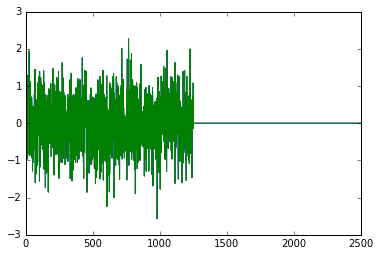

In [311]:
plt.plot(u)
plt.show()